In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, silhouette_score
import numpy as np

# Paths
sample = ['Mouse kidney']
if 'Mouse kidney' in sample:
    scRNA_path = "/root/s3/projects/SSI/mouse_kidney_noaug/GSE157079_P0_adult_AUGMENTED.h5ad" 
    ST_path    = "/root/s3/projects/SSI/mouse_kidney_aug03/Puck_191223_19_corr_pruned_inplace_CoDi_KLD.h5ad"
    sc_annotation = "clusters_mod"
    st_annotation = "CoDi_contrastive"
    emb_sc = np.load("/root/s3/projects/SSI/mouse_kidney_noaug/GSE157079_P0_adult_SC_embeddings.npy")
    emb_st = np.load("/root/s3/projects/SSI/mouse_kidney_aug03/Puck_191223_19_corr_pruned_inplace_ST_embeddings.npy")  
else:
    scRNA_path = "/root/repositories/CoDi/starmap_sc_rna_sparse_AUGMENTED.h5ad"
    ST_path    = "/root/repositories/CoDi/starmap2/dataset10_st_CoDi_KLD.h5ad" 
    sc_annotation = "celltype"
    st_annotation = "CoDi_contrastive"
    emb_sc = np.load("/root/repositories/CoDi/starmap_sc_rna_sparse_SC_embeddings.npy")
    emb_st = np.load("/root/repositories/CoDi/dataset10_st_ST_embeddings.npy")

def preprocess_and_pca(path, label_key, n_hvg=5000, n_pca=128):
    """Load, normalize if needed, extract HVGs, PCA"""
    adata = sc.read_h5ad(path)

    # Remove empty cells (zero total count)
    # sc.pp.filter_cells(adata, min_counts=5)
    # sc.pp.filter_genes(adata, min_counts=5)

    # Normalization (skip if already normalized)
    if "log1p" not in adata.uns.keys():
        # --- 2️⃣ Ensure dense float matrix ---
        if issparse(adata.X):
            adata.X = adata.X.toarray()
        adata.X = adata.X.astype(np.float64)
        sc.pp.normalize_total(adata, target_sum=1e4)
        adata.X = np.nan_to_num(adata.X, nan=0.0, posinf=0.0, neginf=0.0)
        sc.pp.log1p(adata)
        adata.X[~np.isfinite(adata.X)] = 0

    print(f"Remaining genes: {adata.n_vars}")
    print(f"Any NaNs left? {np.isnan(adata.X).sum()}, Any infs? {np.isinf(adata.X).sum()}")

    # HVGs
    if "highly_variable" not in adata.var.keys():
        print(len(adata.var))
        sc.pp.highly_variable_genes(adata, n_top_genes=np.min([n_hvg, len(adata.var)]), subset=True)

    # Scale, PCA, neighbors
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, n_comps=n_pca, svd_solver="arpack")

    return adata

# --- Run for both datasets ---
adata_scRNA = preprocess_and_pca(scRNA_path, sc_annotation)
adata_ST = preprocess_and_pca(ST_path, st_annotation)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.metrics import davies_bouldin_score, silhouette_score



# --- Extract PCA embeddings ---
X_pca_sc = adata_scRNA.obsm["X_pca"]
X_pca_st = adata_ST.obsm["X_pca"]
labels_sc = adata_scRNA.obs[sc_annotation].astype(str).to_numpy()
labels_st = adata_ST.obs[st_annotation].astype(str).to_numpy()

def umap_2(emb):
    umap_model = umap.UMAP(n_components=2, metric="cosine", random_state=42,
                       n_neighbors=50)
    return umap_model.fit_transform(emb)


# --- UMAP projection (same settings for all) ---
scRNA_umap_pca = umap_2(X_pca_sc)
ST_umap_pca = umap_2(X_pca_st)
scRNA_umap_emb = umap_2(emb_sc)
ST_umap_emb = umap_2(emb_st)

# --- Compute clustering metrics ---
dbi_sc_pca = davies_bouldin_score(scRNA_umap_pca, labels_sc)
sil_sc_pca = silhouette_score(scRNA_umap_pca, labels_sc)

dbi_st_pca = davies_bouldin_score(ST_umap_pca, labels_st)
sil_st_pca = silhouette_score(ST_umap_pca, labels_st)

dbi_sc_emb = davies_bouldin_score(scRNA_umap_emb, labels_sc)
sil_sc_emb = silhouette_score(scRNA_umap_emb, labels_sc)

dbi_st_emb = davies_bouldin_score(ST_umap_emb, labels_st)
sil_st_emb = silhouette_score(ST_umap_emb, labels_st)

# --- Consistent color palette ---
clusters_all = np.concatenate([labels_sc, labels_st])
# Create mapping with your custom palette
unique_clusters = sorted(set(clusters_all))   # consistent ordering
cluster_palette = [
    "#1f77b4","#ff7f0e","#279e68","#d62728","#aa40fc",
    "#e377c2","#b5bd61","#17becf","#aec7e8","#ffbb78","#98df8a",
    "#ff9896","#c5b0d5","#c49c94","#f7b6d2","#dbdb8d","#9edae5",
    "#ad494a","#8c6d31","#b4d2b1","#568f8b","#1d4a60","#cd7e59",
    "#ddb247","#d15252","#264653","#2a9d8f","#e9c46a","#f4a261",
    "#e76f51","#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c",
    "#fbf8cc","#fde4cf","#ffcfd2","#f1c0e8","#cfbaf0","#a3c4f3",
    "#90dbf4","#8eecf5","#8359A3","#5e503f","#33CC99","#F2C649",
    "#B94E48","#0095B7","#FF681F","#e0aaff","#FED85D","#0a0908",
    "#C32148","#98f5e1","#000000","#FFFF00"
]

# Make sure palette length ≥ number of clusters
assert len(cluster_palette) >= len(unique_clusters), "Not enough colors for all clusters!"

cluster_color_dict = {c: cluster_palette[i] for i, c in enumerate(unique_clusters)}

colors_sc_pca = [cluster_color_dict[l] for l in labels_sc]
colors_st_pca = [cluster_color_dict[l] for l in labels_st]
colors_sc_emb = [cluster_color_dict[l] for l in labels_sc]
colors_st_emb = [cluster_color_dict[l] for l in labels_st]

/tmp/ipykernel_2179/4080317236.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


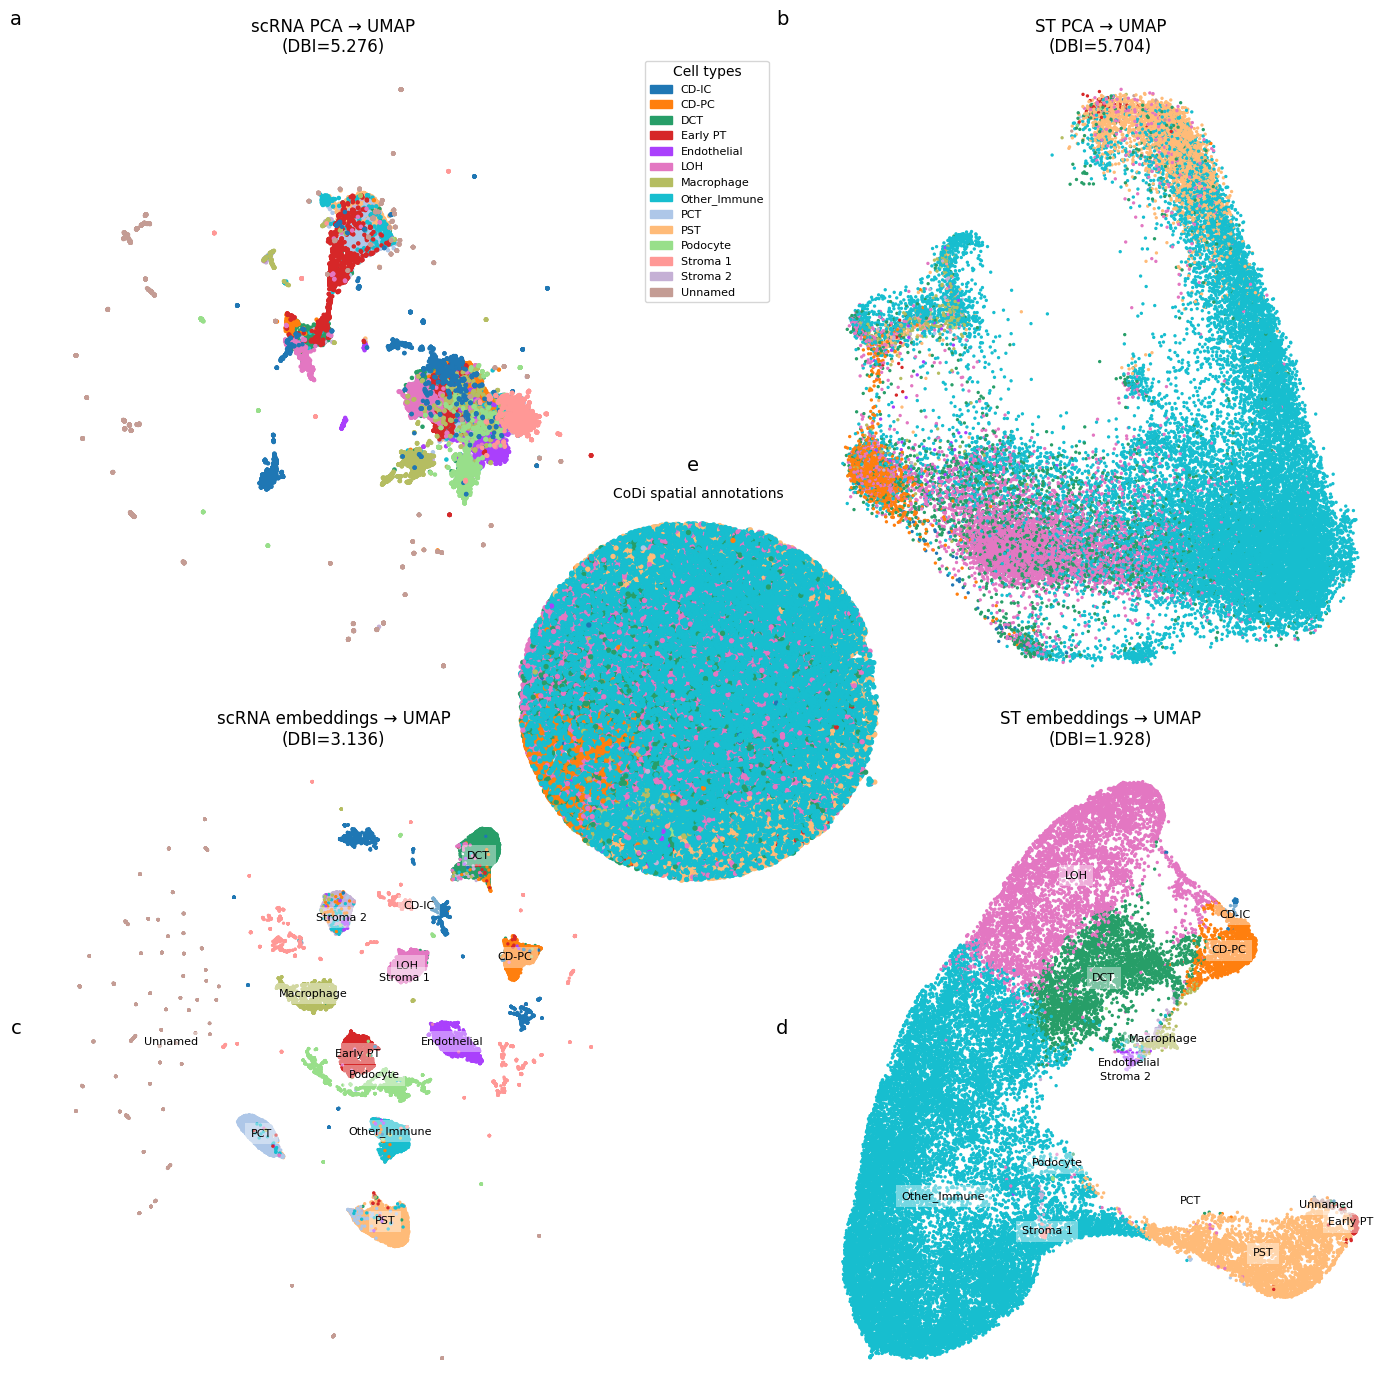

In [82]:
# --- Plot 2x2 figure ---
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
plt.rcParams["font.family"] = "DejaVu Sans"
marker_size = 2
# a) scRNA PCA → UMAP
axes[0,0].scatter(scRNA_umap_pca[:,0], scRNA_umap_pca[:,1],
                  c=colors_sc_pca, s=marker_size)
axes[0,0].set_title(f"scRNA PCA → UMAP\n(DBI={dbi_sc_pca:.3f})") #, Sil={sil_sc_pca:.3f})")

# b) ST PCA → UMAP
axes[0,1].scatter(ST_umap_pca[:,0], ST_umap_pca[:,1],
                  c=colors_st_pca, s=marker_size)
axes[0,1].set_title(f"ST PCA → UMAP\n(DBI={dbi_st_pca:.3f})")  #, Sil={sil_st_pca:.3f})")

# c) scRNA embedding → UMAP
axes[1,0].scatter(scRNA_umap_emb[:,0], scRNA_umap_emb[:,1],
                  c=colors_sc_emb, s=marker_size)
axes[1,0].set_title(f"scRNA embeddings → UMAP\n(DBI={dbi_sc_emb:.3f})")  #, Sil={sil_sc_emb:.3f})")

# d) ST embedding → UMAP
axes[1,1].scatter(ST_umap_emb[:,0], ST_umap_emb[:,1],
                  c=colors_st_emb, s=marker_size)
axes[1,1].set_title(f"ST embeddings → UMAP\n(DBI={dbi_st_emb:.3f})")  #, Sil={sil_st_emb:.3f})")

# Add cluster labels to panels c and d
for ax, coords, labels in [(axes[1,0], scRNA_umap_emb, labels_sc),
                           (axes[1,1], ST_umap_emb, labels_st)]:
    df = pd.DataFrame({"x": coords[:,0], "y": coords[:,1], "label": labels})
    for label in df["label"].unique():
        mean_x = df[df["label"] == label]["x"].mean()
        mean_y = df[df["label"] == label]["y"].mean()
        ax.text(mean_x, mean_y, str(label),
                fontsize=8, ha="center", va="center",
                bbox=dict(facecolor="white", alpha=0.4, edgecolor="none"))

# Remove ticks, grids, and frames
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

import matplotlib.patches as mpatches

# --- after plotting panel a) ---
axes[0,0].scatter(scRNA_umap_pca[:,0], scRNA_umap_pca[:,1],
                  c=colors_sc_pca, s=5)

# Build legend handles from cluster_color_dict
handles = [mpatches.Patch(color=col, label=lab) for lab, col in cluster_color_dict.items()]
axes[0,0].legend(handles=handles,
                 bbox_to_anchor=(1.05, 1),  # place outside plot
                 loc="upper left",
                 borderaxespad=0.,
                 fontsize=8,
                 title="Cell types")

# --- Subplot labels a–d with adjusted positions ---
labels = ["a", "b", "c", "d"]
for lbl, ax in zip(labels, axes.flat):
    if lbl in ["a", "b"]:
        ax.text(-0.05, 1.05, lbl, transform=ax.transAxes,
                fontsize=14, va="bottom", ha="right")
    else:
        # move c and d halfway lower (closer to the middle)
        ax.text(-0.05, 0.55, lbl, transform=ax.transAxes,
                fontsize=14, va="bottom", ha="right")

# --- Add overlay axis for central spatial plot (smaller than before) ---
ax_center = fig.add_axes([0.36, 0.36, 0.28, 0.28])  # smaller central overlay
ax_center.scatter(adata_ST.obsm["spatial"][:, 0],
                  adata_ST.obsm["spatial"][:, 1],
                  c=colors_st_emb, s=8)
ax_center.set_title("CoDi spatial annotations", fontsize=10)

# --- Style for central axis ---
ax_center.set_xticks([])
ax_center.set_yticks([])
ax_center.grid(False)
for spine in ax_center.spines.values():
    spine.set_visible(False)
ax_center.set_zorder(10)
ax_center.patch.set_alpha(0)  # transparent background

# --- Label 'e' for center panel ---
ax_center.text(0.5, 1.08, "e", transform=ax_center.transAxes,
               fontsize=14, va="bottom", ha="right")


plt.tight_layout()
plt.savefig("scRNA_ST_umap_uniform.pdf", dpi=300, bbox_inches="tight")
plt.show()


/tmp/ipykernel_2179/3063495600.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


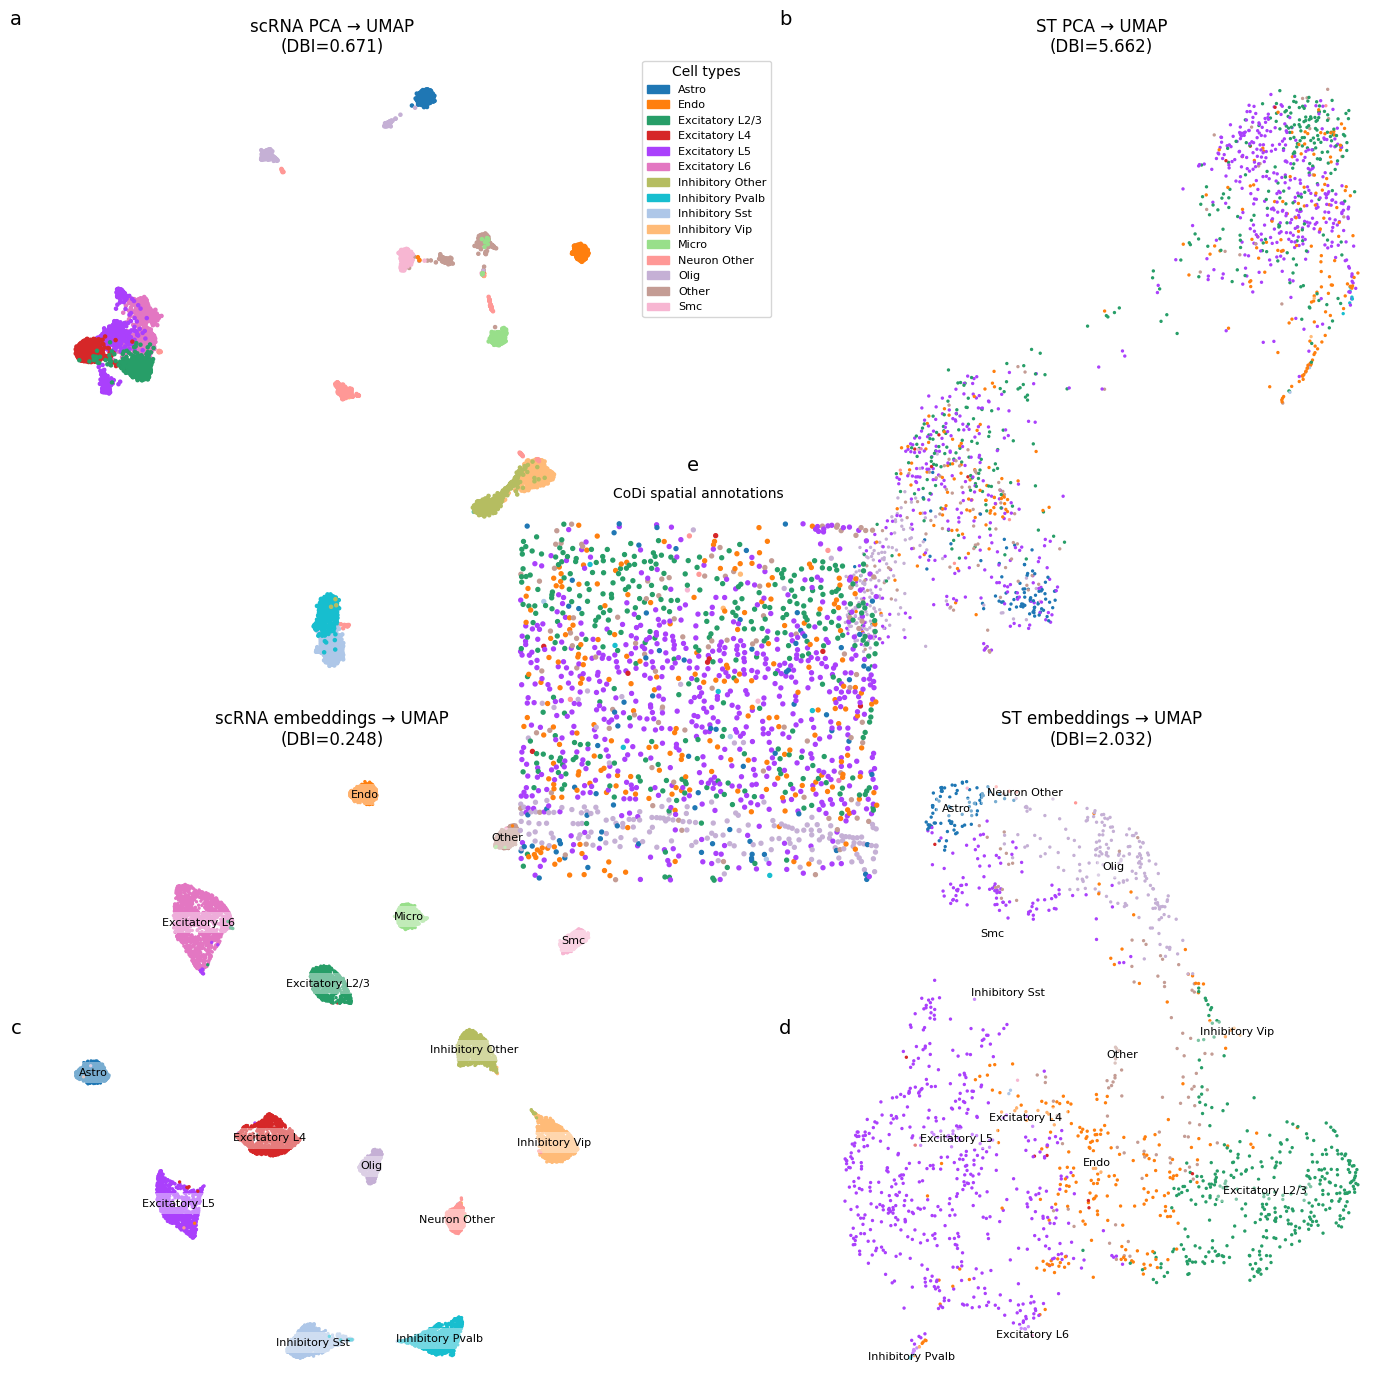

In [85]:
# --- Plot 2x2 figure ---
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
plt.rcParams["font.family"] = "DejaVu Sans"
marker_size = 2
# a) scRNA PCA → UMAP
axes[0,0].scatter(scRNA_umap_pca[:,0], scRNA_umap_pca[:,1],
                  c=colors_sc_pca, s=marker_size)
axes[0,0].set_title(f"scRNA PCA → UMAP\n(DBI={dbi_sc_pca:.3f})") #, Sil={sil_sc_pca:.3f})")

# b) ST PCA → UMAP
axes[0,1].scatter(ST_umap_pca[:,0], ST_umap_pca[:,1],
                  c=colors_st_pca, s=marker_size)
axes[0,1].set_title(f"ST PCA → UMAP\n(DBI={dbi_st_pca:.3f})")  #, Sil={sil_st_pca:.3f})")

# c) scRNA embedding → UMAP
axes[1,0].scatter(scRNA_umap_emb[:,0], scRNA_umap_emb[:,1],
                  c=colors_sc_emb, s=marker_size)
axes[1,0].set_title(f"scRNA embeddings → UMAP\n(DBI={dbi_sc_emb:.3f})")  #, Sil={sil_sc_emb:.3f})")

# d) ST embedding → UMAP
axes[1,1].scatter(ST_umap_emb[:,0], ST_umap_emb[:,1],
                  c=colors_st_emb, s=marker_size)
axes[1,1].set_title(f"ST embeddings → UMAP\n(DBI={dbi_st_emb:.3f})")  #, Sil={sil_st_emb:.3f})")

# Add cluster labels to panels c and d
for ax, coords, labels in [(axes[1,0], scRNA_umap_emb, labels_sc),
                           (axes[1,1], ST_umap_emb, labels_st)]:
    df = pd.DataFrame({"x": coords[:,0], "y": coords[:,1], "label": labels})
    for label in df["label"].unique():
        mean_x = df[df["label"] == label]["x"].mean()
        mean_y = df[df["label"] == label]["y"].mean()
        ax.text(mean_x, mean_y, str(label),
                fontsize=8, ha="center", va="center",
                bbox=dict(facecolor="white", alpha=0.4, edgecolor="none"))

# Remove ticks, grids, and frames
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

import matplotlib.patches as mpatches

# --- after plotting panel a) ---
axes[0,0].scatter(scRNA_umap_pca[:,0], scRNA_umap_pca[:,1],
                  c=colors_sc_pca, s=5)

# Build legend handles from cluster_color_dict
handles = [mpatches.Patch(color=col, label=lab) for lab, col in cluster_color_dict.items()]
axes[0,0].legend(handles=handles,
                 bbox_to_anchor=(1.05, 1),  # place outside plot
                 loc="upper left",
                 borderaxespad=0.,
                 fontsize=8,
                 title="Cell types")

# --- Subplot labels a–d with adjusted positions ---
labels = ["a", "b", "c", "d"]
for lbl, ax in zip(labels, axes.flat):
    if lbl in ["a", "b"]:
        ax.text(-0.05, 1.05, lbl, transform=ax.transAxes,
                fontsize=14, va="bottom", ha="right")
    else:
        # move c and d halfway lower (closer to the middle)
        ax.text(-0.05, 0.55, lbl, transform=ax.transAxes,
                fontsize=14, va="bottom", ha="right")

# --- Add overlay axis for central spatial plot (smaller than before) ---
ax_center = fig.add_axes([0.36, 0.36, 0.28, 0.28])  # smaller central overlay
ax_center.scatter(adata_ST.obsm["spatial"][:, 0],
                  adata_ST.obsm["spatial"][:, 1],
                  c=colors_st_emb, s=8)
ax_center.set_title("CoDi spatial annotations", fontsize=10)

# --- Style for central axis ---
ax_center.set_xticks([])
ax_center.set_yticks([])
ax_center.grid(False)
for spine in ax_center.spines.values():
    spine.set_visible(False)
ax_center.set_zorder(10)
ax_center.patch.set_alpha(0)  # transparent background

# --- Label 'e' for center panel ---
ax_center.text(0.5, 1.08, "e", transform=ax_center.transAxes,
               fontsize=14, va="bottom", ha="right")


plt.tight_layout()
plt.savefig("sup_embeddings.pdf", dpi=300, bbox_inches="tight")
plt.show()
